In [1]:
from dotenv import load_dotenv,find_dotenv

_ = load_dotenv(find_dotenv(),override=True)

In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
from IPython.display import Image, display
from pydantic import BaseModel, Field
import os
import asyncio
import nest_asyncio
import operator
from langgraph.constants import Send
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")


### Create Node


In [3]:
from langchain_deepseek import ChatDeepSeek
from node.lg_llm import llm,writer_llm,draft
from node.lg_state import State,WriterState
from node.lg_node import web_search, web_parse, draft_news, combine_news, assign_writer, generate_news_image_node, generate_news_title, save_news_to_dynamodb
from node.lg_node import save_image_to_s3

2025-02-27 21:59:45,103 - INFO - find .env file
2025-02-27 21:59:45,103 - INFO - all env variables are set


### build most update graph

In [4]:
workflow = StateGraph(State)

workflow.add_node("web_search", web_search)
workflow.add_node("web_parse", web_parse)
workflow.add_node("draft_news", draft_news)
#workflow.add_node("assign_writer", assign_writer)
workflow.add_node("combine_news", combine_news)
workflow.add_node("generate_news_image", generate_news_image_node)
workflow.add_node("save_image_to_s3", save_image_to_s3)
workflow.add_node("generate_news_title", generate_news_title)
workflow.add_node("save_news_to_dynamodb", save_news_to_dynamodb)


workflow.add_edge(START, "web_search")
workflow.add_edge("web_search", "web_parse")
workflow.add_conditional_edges(
    "web_parse", assign_writer, ["draft_news"]
)
workflow.add_edge("draft_news", "combine_news")

workflow.add_edge("combine_news", "generate_news_image")
workflow.add_edge("generate_news_image", "save_image_to_s3")
workflow.add_edge("save_image_to_s3", "save_news_to_dynamodb")
workflow.add_edge("combine_news", "generate_news_title")
workflow.add_edge("generate_news_title", "save_news_to_dynamodb")
workflow.add_edge("save_news_to_dynamodb", END)


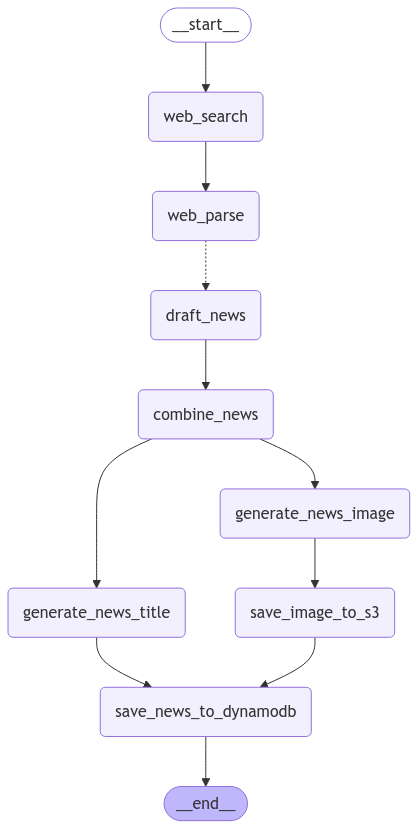

In [5]:
chain = workflow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

In [6]:
chain.invoke({"topic": "china deepseek opensource week"})

2025-02-27 21:59:45,905 - INFO - search success 'news about china deepseek opensource week', find 2 results
2025-02-27 21:59:45,910 - INFO - Starting to fetch and extract content from 2 URLs
2025-02-27 21:59:47,468 - INFO - Completed extraction: 2 successful, 0 failed
2025-02-27 21:59:48,426 - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 21:59:48,427 - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"


debug: inside combine_news
debug: China's DeepSeek Shakes the AI Industry with Open Source Week

Liang Wenfeng, the founding CEO of DeepSeek, has once again positioned his company at the forefront of the AI industry with the announcement of DeepSeek's Open Source Week. This event has sent shockwaves through the market, particularly affecting Nvidia, which saw a significant drop in its stock value following the announcement. In just six days, Nvidia's market cap plummeted by $300 billion, a direct consequence of DeepSeek's groundbreaking revelations.

DeepSeek's Open Source Week kicked off with the introduction of FlashMLA, a revolutionary technology that challenges Nvidia's dominance in the AI training sector. FlashMLA enhances the performance of Nvidia's budget H800 chips, enabling them to process long-text 10 times faster and even outperform the premium H100 chips in reasoning tasks by a factor of two. This innovation is a game-changer, as it unlocks untapped potential in existing GP

2025-02-27 22:00:26,701 - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 22:01:58,112 - INFO - Starting news image generation process
2025-02-27 22:01:58,113 - INFO - Starting title generation
2025-02-27 22:01:58,793 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 22:01:58,796 - INFO - Title generated successfully: '"DeepSeek Disrupts AI Norms"'
2025-02-27 22:02:00,149 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 22:02:00,154 - INFO - Generating image using DALL-E model
2025-02-27 22:02:16,799 - INFO - HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"
2025-02-27 22:02:16,802 - INFO - Image generated successfully
2025-02-27 22:02:16,948 - INFO - S3Handler initialized for bucket: newspicture in region: us-east-1
2025-02-27 22:02:16,949 - INFO - Attempting to upload image from https://oaidalleapiprod

test1 https://newspicture.s3.amazonaws.com/images/china deepseek opensource week/2025-02-28.jpg


2025-02-27 22:02:21,958 - INFO - Saving article with topic_id: china deepseek opensource week, title: '"DeepSeek Disrupts AI Norms"...'
2025-02-27 22:02:22,157 - INFO - Successfully saved article '"DeepSeek Disrupts AI Norms"...' to DynamoDB


debug: s3_image_url = None


2025-02-27 22:02:22,182 - INFO - DynamoDBHandler initialized for table: new_article_table in region: us-east-1
2025-02-27 22:02:27,188 - INFO - Saving article with topic_id: china deepseek opensource week, title: '"DeepSeek Disrupts AI Norms"...'
2025-02-27 22:02:27,371 - INFO - Successfully saved article '"DeepSeek Disrupts AI Norms"...' to DynamoDB


debug: s3_image_url = https://newspicture.s3.amazonaws.com/images/china deepseek opensource week/2025-02-28.jpg


{'topic': 'china deepseek opensource week',
 'websites_links': ['https://thechinaacademy.org/how-deepseek-nuked-nvidia-again/',
  'https://www.fintechweekly.com/magazine/articles/deepseek-in-fintech-ethical-considerations'],
 'websites_content': ['How DeepSeek Nuked Nvidia Again?\nLiang Wenfeng, the founding CEO of DeepSeek\nOn February 21, Nvidia’s stock—after a brief rebound—nosedived straight to hell again. In just six days, $300 billion vanished from its market cap. That’s because DeepSeek announced its Open Source Week on the 21st, and investors around the world knew Nvidia was about to face another round of nuclear strikes. Unsurprisingly, a revolutionary technology that blew up one of Nvidia’s key AI training moats is published on the first day and is free for all.\nFor years, Nvidia convinced the entire AI industry that smarter AI required ever-increasing computing power—and that Nvidia’s newest GPUs would always crush previous generations. This created a vicious cycle: Every p

In [7]:
from config.topic import TOPICS
topic_name = [i["name"]  for i in TOPICS if i["id"] == "cocktails" ]
topic_name

['Cocktails']